In [8]:
import logging
import os
import sys
import glob
from hydra import initialize, compose
from omegaconf import OmegaConf

# Jupyter 노트북에서 상위 디렉토리를 Python 경로에 추가
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from src.data.MNIST_data import MNISTDataModule
from src.models.auto_encoder import AutoEncoder
from src.utils.visualize_autoencoder import (
    visualize_latent_space,
    generate_from_latent,
    generate_latent_grid,
    visualize_sample_data,
)

# 모델 이름 (Hydra 로그 디렉토리 구조)
MODEL_NAME = "autoencoder"

# run_timestamp 설정 (None이면 가장 최근 실행 자동 선택)
run_timestamp = None  # 예: "2025-12-20/16-44-09"

# 가장 최근 실행 찾기
def find_latest_run(base_dir=f"../saved/hydra_logs/{MODEL_NAME}"):
    """가장 최근 실행 디렉토리 찾기"""
    pattern = os.path.join(base_dir, "*", "*")
    all_runs = glob.glob(pattern)
    
    if not all_runs:
        raise FileNotFoundError(f"No run directories found in {base_dir}")
    
    # 날짜/시간 기준으로 정렬
    all_runs.sort()
    latest_run = all_runs[-1]
    
    # 상대 경로로 변환
    run_timestamp = os.path.relpath(latest_run, base_dir)
    
    return run_timestamp

if run_timestamp is None:
    run_timestamp = find_latest_run()
    print(f"✅ Using latest run: {run_timestamp}")
else:
    print(f"✅ Using specified run: {run_timestamp}")

# Hydra 설정 로드
with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="autoencoder")

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s|%(levelname)s|%(filename)s:%(lineno)d| %(message)s',
    datefmt='%H:%M:%S',
    force=True,
)

log = logging.getLogger(__name__)
log.info("=" * 80)
log.info("Configuration:")
log.info(OmegaConf.to_yaml(cfg))
log.info("=" * 80)

18:06:54|INFO|2316794760.py:65| ================================================================================
18:06:54|INFO|2316794760.py:66| Configuration:
18:06:54|INFO|2316794760.py:67| tensorboard:
  save_dir: ./saved/tensorboard_logs
checkpoint:
  save_top_k: 1
  monitor: val_loss
  mode: min
seed: 42
float32_matmul_precision: medium
model_name: autoencoder
data:
  data_dir: ~/data/
  batch_size: 32
  target_labels:
  - 0
  - 1
  - 3
  - 8
model:
  latent_dim: 2
  hidden_dim: 256
training:
  max_epochs: 2
  lr: 0.001
  weight_decay: 0.1
  T_max: 100
trainer:
  devices: auto
  log_every_n_steps: 5
  val_check_interval: 1.0
  enable_progress_bar: true
  enable_model_summary: true

18:06:54|INFO|2316794760.py:68| ================================================================================


✅ Using latest run: 2025-12-20/18-05-39


In [9]:
# 데이터 로드
mnist = MNISTDataModule(
    data_dir=cfg.data.data_dir,
    batch_size=cfg.data.batch_size,
    target_labels=cfg.data.target_labels,
)
mnist.setup("fit")

log.info(f"Train dataset size: {len(mnist.train_dataloader().dataset)}")
log.info(f"Val dataset size: {len(mnist.val_dataloader().dataset)}")
log.info(f"Test dataset size: {len(mnist.test_dataloader().dataset)}")

18:06:54|INFO|MNIST_data.py:37| 필터링: [0, 1, 3, 8]
18:07:02|INFO|2249619518.py:9| Train dataset size: 22182
18:07:02|INFO|2249619518.py:10| Val dataset size: 2465
18:07:02|INFO|2249619518.py:11| Test dataset size: 4099


In [10]:
# 체크포인트 로드 (Hydra 실행 디렉토리 기준)
checkpoint_dir = os.path.join('..', 'saved', 'hydra_logs', MODEL_NAME, run_timestamp, 'checkpoints')

if not os.path.exists(checkpoint_dir):
    raise FileNotFoundError(f"Checkpoint directory not found: {checkpoint_dir}")

# 체크포인트 파일 찾기
checkpoints = glob.glob(os.path.join(checkpoint_dir, "autoencoder-*.ckpt"))

if not checkpoints:
    raise FileNotFoundError(f"No checkpoints found in {checkpoint_dir}")

# 가장 좋은 체크포인트 선택 (val_loss 기준)
def extract_val_loss(ckpt_path):
    filename = os.path.basename(ckpt_path)
    try:
        loss_str = filename.split("val_loss=")[1].split(".ckpt")[0].split("-")[0]
        return float(loss_str)
    except:
        return float('inf')

best_checkpoint = min(checkpoints, key=extract_val_loss)
log.info(f"✅ Loading checkpoint: {best_checkpoint}")

autoencoder = AutoEncoder.load_from_checkpoint(best_checkpoint, weights_only=False)
autoencoder.eval()
log.info("✅ Model loaded successfully")

18:07:02|INFO|415923401.py:23| ✅ Loading checkpoint: ../saved/hydra_logs/autoencoder/2025-12-20/18-05-39/checkpoints/autoencoder-epoch=01-val_loss=0.04.ckpt
18:07:02|INFO|415923401.py:27| ✅ Model loaded successfully


# 1. 샘플 데이터 시각화
원본 이미지와 재구성된 이미지를 비교합니다.

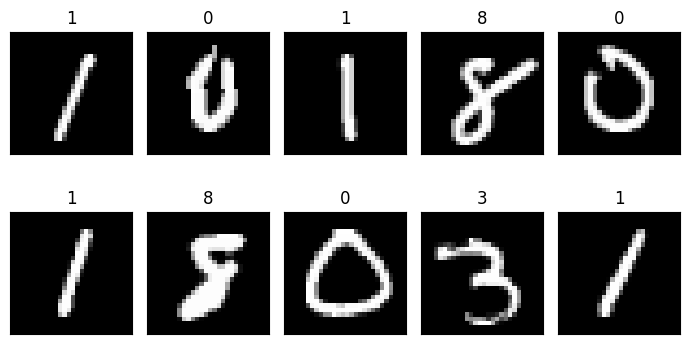

In [11]:
# 테스트 데이터로 샘플 시각화
data_loader = mnist.train_dataloader()
visualize_sample_data(data_loader)

# 2. Latent Space 시각화
2D latent space에 테스트 데이터를 투영하여 클러스터링을 확인합니다.

18:07:03|INFO|visualize_autoencoder.py:67| Model is on device: cuda:0
18:07:03|INFO|visualize_autoencoder.py:96| Latent coordinates shape: (4099, 2)
18:07:03|INFO|visualize_autoencoder.py:97| Labels shape: (4099,)


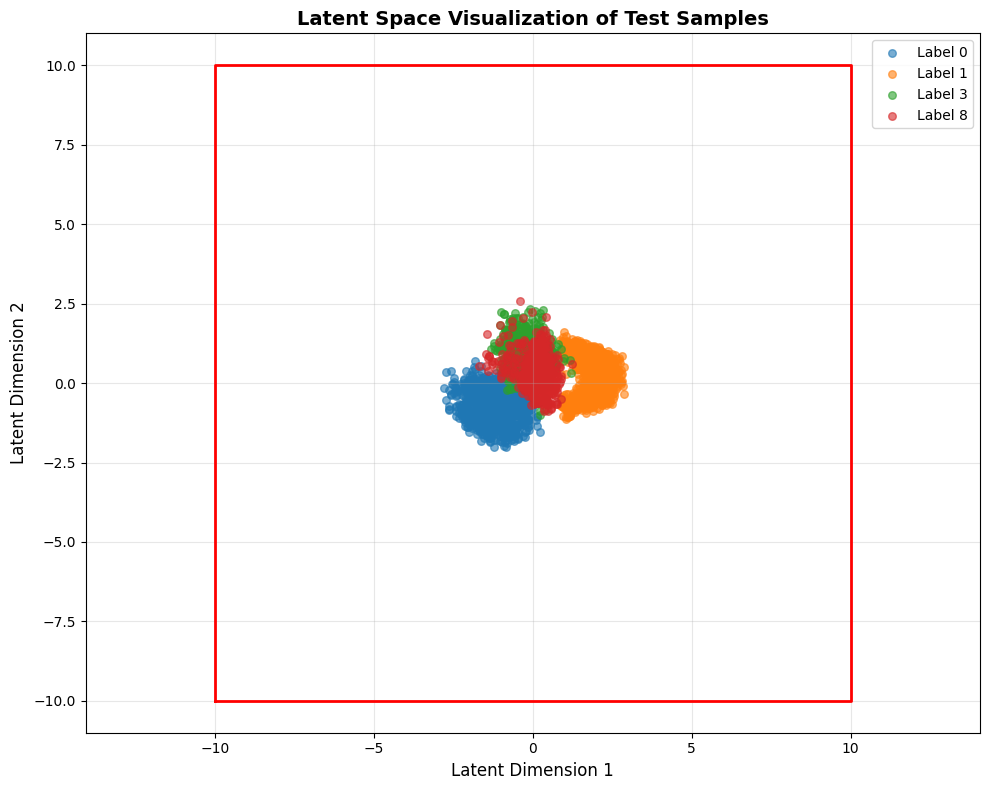


=== Latent Space Statistics ===

Label 0:
  Count: 980
  Dim 1 - Mean: -1.1046, Std: 0.6078
  Dim 2 - Mean: -0.6682, Std: 0.5296

Label 1:
  Count: 1135
  Dim 1 - Mean: 1.7932, Std: 0.4564
  Dim 2 - Mean: 0.2829, Std: 0.6327

Label 3:
  Count: 1010
  Dim 1 - Mean: -0.2095, Std: 0.3755
  Dim 2 - Mean: 0.7486, Std: 0.4832

Label 8:
  Count: 974
  Dim 1 - Mean: 0.1489, Std: 0.3502
  Dim 2 - Mean: 0.2630, Std: 0.4631


In [12]:
# Latent space 시각화
visualize_latent_space(
    autoencoder,
    mnist,
    cfg.data.target_labels,
    use_train=False
)

# 3. Latent Space에서 이미지 생성
특정 latent 좌표에서 이미지를 생성합니다.

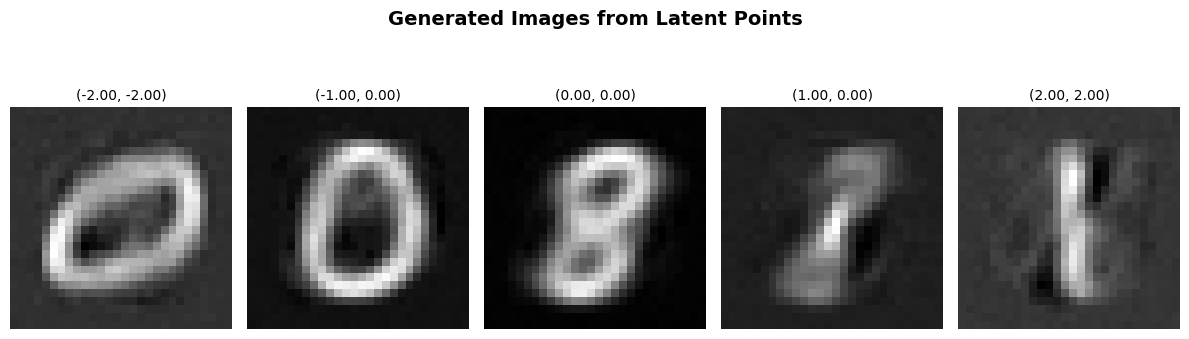

array([[[-1.55914575e-02,  1.58929825e-03,  1.95470043e-02, ...,
         -2.56187469e-03,  1.03100017e-03, -2.76564509e-02],
        [-8.21763836e-03, -9.50278528e-03, -2.39459053e-02, ...,
         -3.30506861e-02,  1.60896294e-02, -9.31881368e-06],
        [-1.03739277e-03,  9.47603956e-03, -1.40415691e-02, ...,
         -4.66537103e-03, -1.93118565e-02,  3.63973528e-03],
        ...,
        [ 1.38355643e-02, -7.61071593e-03,  6.41631521e-03, ...,
          8.73595476e-03, -1.68598443e-03, -5.45074046e-03],
        [-1.57635026e-02, -1.32682044e-02,  7.88463093e-03, ...,
          3.52678522e-02, -6.87624142e-03,  3.67741846e-03],
        [-3.58639248e-02, -1.13215446e-02,  9.11747664e-03, ...,
          6.04592264e-03, -1.93099491e-02,  7.07455911e-03]],

       [[-3.45572783e-03, -2.75820494e-03,  6.84520230e-03, ...,
          5.89055941e-04, -4.74035740e-03, -4.98923287e-03],
        [-8.04895535e-04,  4.39659413e-03, -1.05297938e-02, ...,
         -4.68619168e-03, -4.09578159e

In [13]:
import torch

# 특정 latent 좌표에서 이미지 생성
latent_points = torch.tensor([
    [-2.0, -2.0],
    [-1.0, 0.0],
    [0.0, 0.0],
    [1.0, 0.0],
    [2.0, 2.0],
])

generate_from_latent(autoencoder, latent_points)

# 4. Latent Space Grid 시각화
Latent space를 그리드로 나누어 각 위치에서 생성되는 이미지를 시각화합니다.

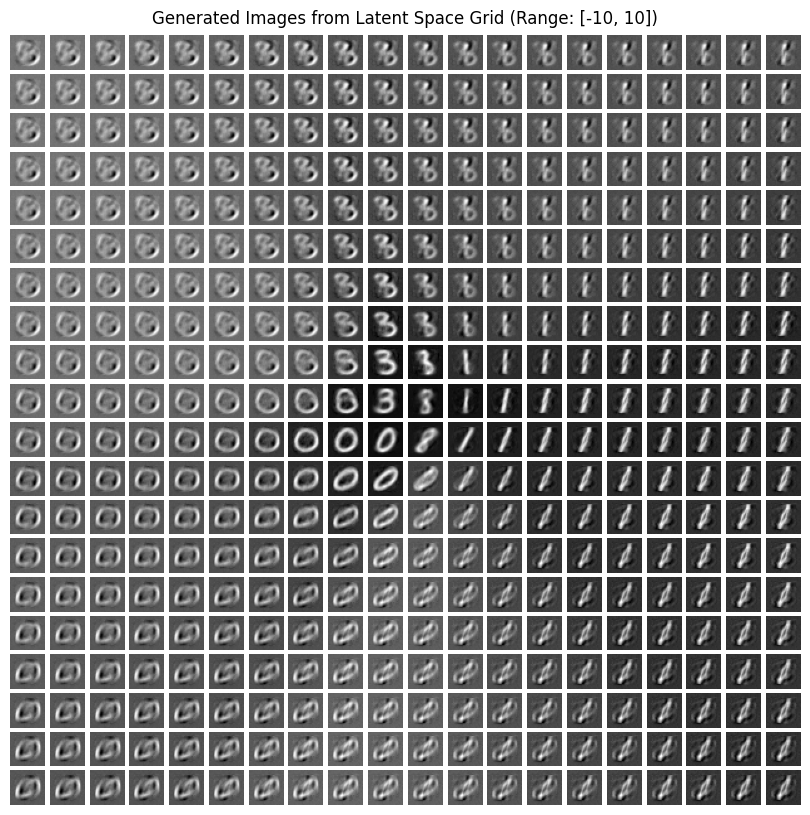

18:07:11|INFO|visualize_autoencoder.py:245| Generated 400 images from latent space grid


In [14]:
# Latent space를 15x15 그리드로 시각화
generate_latent_grid(autoencoder, n_samples=20, latent_range=10)